# EDA

In [1]:
# Importing dataset
import pandas as pd

df = pd.read_csv('../data/f1_lap_data_2023_to_2025.csv')

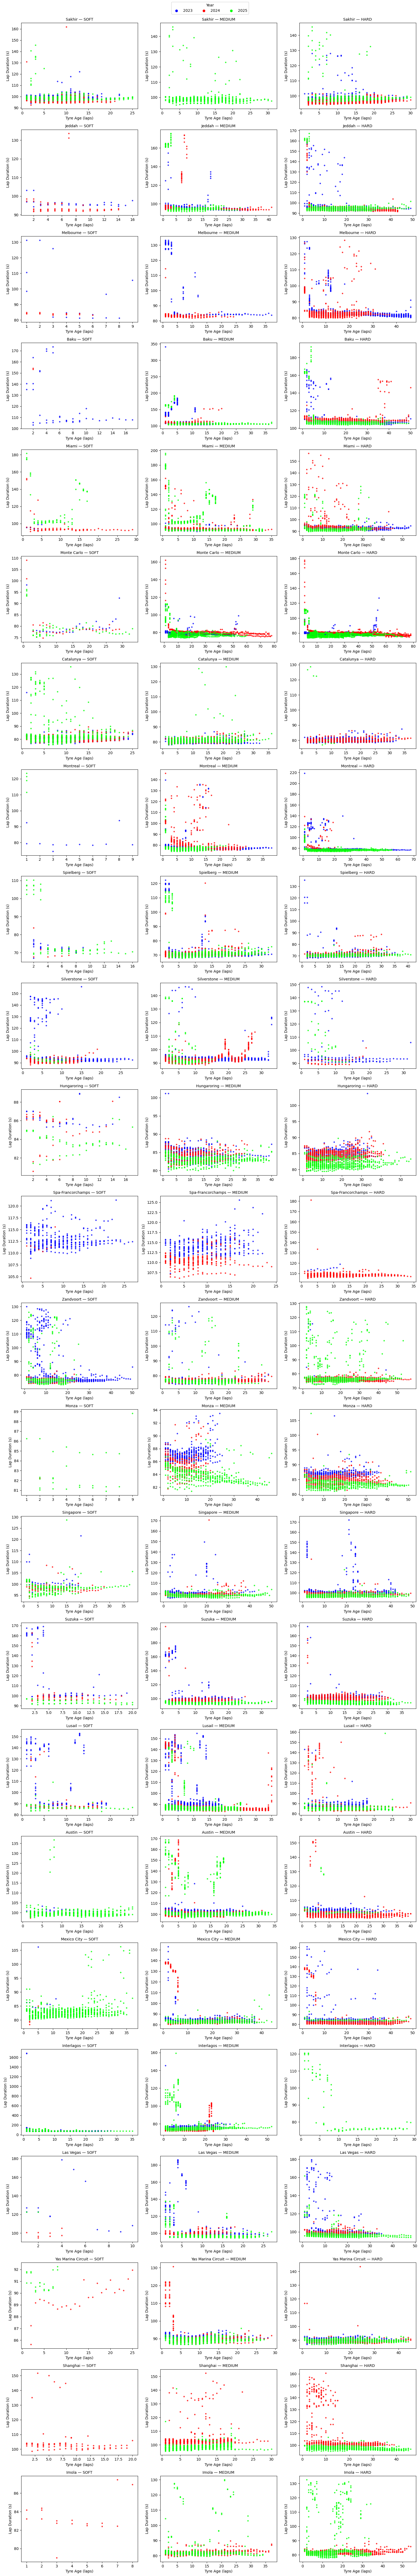

In [2]:
import matplotlib.pyplot as plt

# Filter to only the compounds of interest
dry_compounds = ["SOFT", "MEDIUM", "HARD"]
df_plot = df[df["tyre_compound"].isin(dry_compounds)].copy()

# Get unique tracks
tracks = df_plot["track"].unique()

# Create figure grid: rows = tracks, cols = tyre compounds
n_rows = len(tracks)
n_cols = 3

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(15, 4 * n_rows),
    sharex=False, sharey=False
)

# Create colormap for years
years = sorted(df_plot["year"].unique())
cmap = plt.get_cmap("brg", len(years))
year_to_color = {year: cmap(i) for i, year in enumerate(years)}

# Plotting
for row_idx, track in enumerate(tracks):
    df_track = df_plot[df_plot["track"] == track]

    for col_idx, compound in enumerate(dry_compounds):

        df_tc = df_track[df_track["tyre_compound"] == compound]

        ax = axes[row_idx][col_idx] if n_rows > 1 else axes[col_idx]

        for year in years:
            df_year = df_tc[df_tc["year"] == year]
            ax.scatter(
                df_year["tyre_age_laps"],
                df_year["lap_duration"],
                s=8,
                color=year_to_color[year],
                label=str(year) if row_idx == 0 else None,  # only label top row
                alpha=0.7
            )

        ax.set_title(f"{track} — {compound}", fontsize=10)
        ax.set_xlabel("Tyre Age (laps)")
        ax.set_ylabel("Lap Duration (s)")

# Add legend only once
handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color=year_to_color[y], label=y)
    for y in years
]
fig.legend(handles, [str(y) for y in years], title="Year", loc="upper center", ncol=len(years))

plt.tight_layout(rect=[0, 0, 1.05, 0.995])
plt.show()

In [3]:
baselines = (
    df.groupby(["year", "track", "tyre_compound"])["lap_duration"]
    .quantile(0.2)
        .reset_index()
        .rename(columns={"lap_duration": "year_baseline"})
)

df_delta = df.merge(baselines, on=["year", "track", "tyre_compound"], how="left")

df_delta["lap_delta"] = df_delta["lap_duration"] - df_delta["year_baseline"]
df_delta = df_delta[df_delta["lap_delta"]<20]

In [4]:
baselines[baselines["track"] == "Melbourne"]

year      track tyre_compound  year_baseline
23  2023  Melbourne          HARD        81.6846
24  2023  Melbourne        MEDIUM        83.8824
25  2023  Melbourne          SOFT        81.3310
97  2024  Melbourne          HARD        81.4620
98  2024  Melbourne        MEDIUM        82.6254
99  2024  Melbourne          SOFT        83.5320

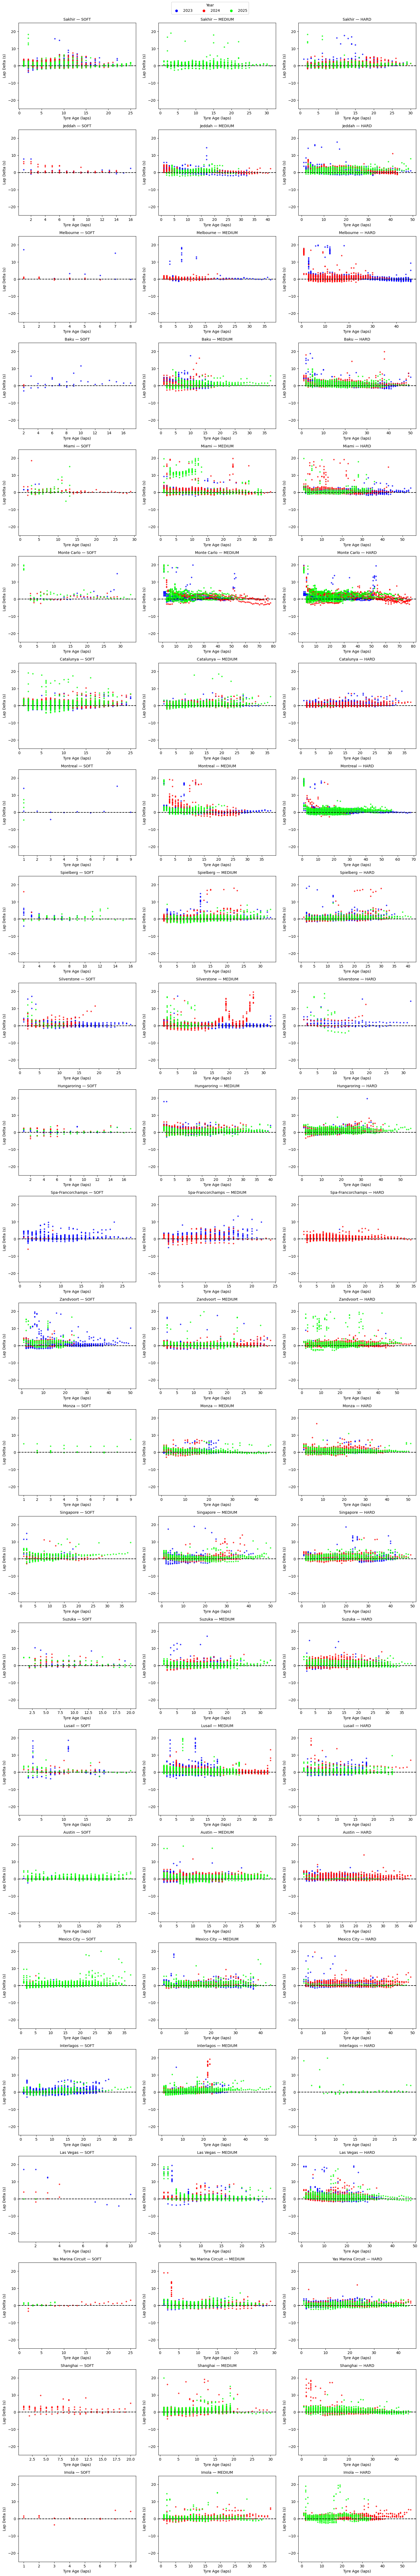

In [5]:
# Replotting with delta lap times

df_plot = df_delta[df_delta["tyre_compound"].isin(dry_compounds)].copy()
df_plot = df_plot[df_plot["is_pit_out_lap"].isin([False])]

# Get unique tracks
tracks = df_plot["track"].unique()

# Create figure grid: rows = tracks, cols = tyre compounds
n_rows = len(tracks)
n_cols = 3

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(15, 4 * n_rows),
    sharex=False, sharey=False
)

# Create colormap for years
years = sorted(df_plot["year"].unique())
cmap = plt.get_cmap("brg", len(years))
year_to_color = {year: cmap(i) for i, year in enumerate(years)}

# Plotting
for row_idx, track in enumerate(tracks):
    df_track = df_plot[df_plot["track"] == track]

    for col_idx, compound in enumerate(dry_compounds):

        df_tc = df_track[df_track["tyre_compound"] == compound]

        ax = axes[row_idx][col_idx] if n_rows > 1 else axes[col_idx]

        for year in years:
            df_year = df_tc[df_tc["year"] == year]
            ax.scatter(
                df_year["tyre_age_laps"],
                df_year["lap_delta"],
                s=8,
                color=year_to_color[year],
                label=str(year) if row_idx == 0 else None,  # only label top row
                alpha=0.7
            )

        ax.set_title(f"{track} — {compound}", fontsize=10)
        ax.set_xlabel("Tyre Age (laps)")
        ax.set_ylabel("Lap Delta (s)")
        ax.set_ylim(-25,25)
        ax.axhline(y=0, color="black", linestyle="--", label="Delta 0")

# Add legend only once
handles = [
    plt.Line2D([0], [0], marker="o", linestyle="", color=year_to_color[y], label=y)
    for y in years
]
fig.legend(handles, [str(y) for y in years], title="Year", loc="upper center", ncol=len(years))

plt.tight_layout(rect=[0, 0, 1.05, 0.995])
plt.show()


### Tyre model

In [6]:
# Import libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

In [7]:
# Init
poly = PolynomialFeatures(degree=2)  # degree=2 is ideal for tyre degradation curves

compounds = ["SOFT", "MEDIUM", "HARD"]
models = {}          # stores trained models
baselines_dict = {}  # store baseline per (track, compound, year)

# Build baseline dictionary for reconstruction
for _, row in baselines.iterrows():
    baselines_dict[(row["track"], row["tyre_compound"], row["year"])] = row["year_baseline"]

In [8]:
# Train model per (track × compound)
for track in df_delta["track"].unique():
    df_track = df_delta[df_delta["track"] == track]

    for comp in compounds:
        df_tc = df_track[df_track["tyre_compound"] == comp]

        if len(df_tc) < 15:   # avoid training on tiny datasets
            continue

        X = df_tc["tyre_age_laps"].values.reshape(-1, 1)
        y = df_tc["lap_delta"].values

        X_poly = poly.fit_transform(X)
        model = LinearRegression().fit(X_poly, y)
        models[(track, comp)] = model

In [9]:
# Helper functions for tyre model

def predict_lap_delta(track, compound, tyre_age):
    model = models[(track, compound)]
    X_poly = poly.transform(np.array([[tyre_age]]))
    return float(model.predict(X_poly)[0])

def predict_lap_time(track, compound, tyre_age, year):
    lap_delta = predict_lap_delta(track, compound, tyre_age)
    baseline = baselines_dict[(track, compound, year)]
    return baseline + lap_delta

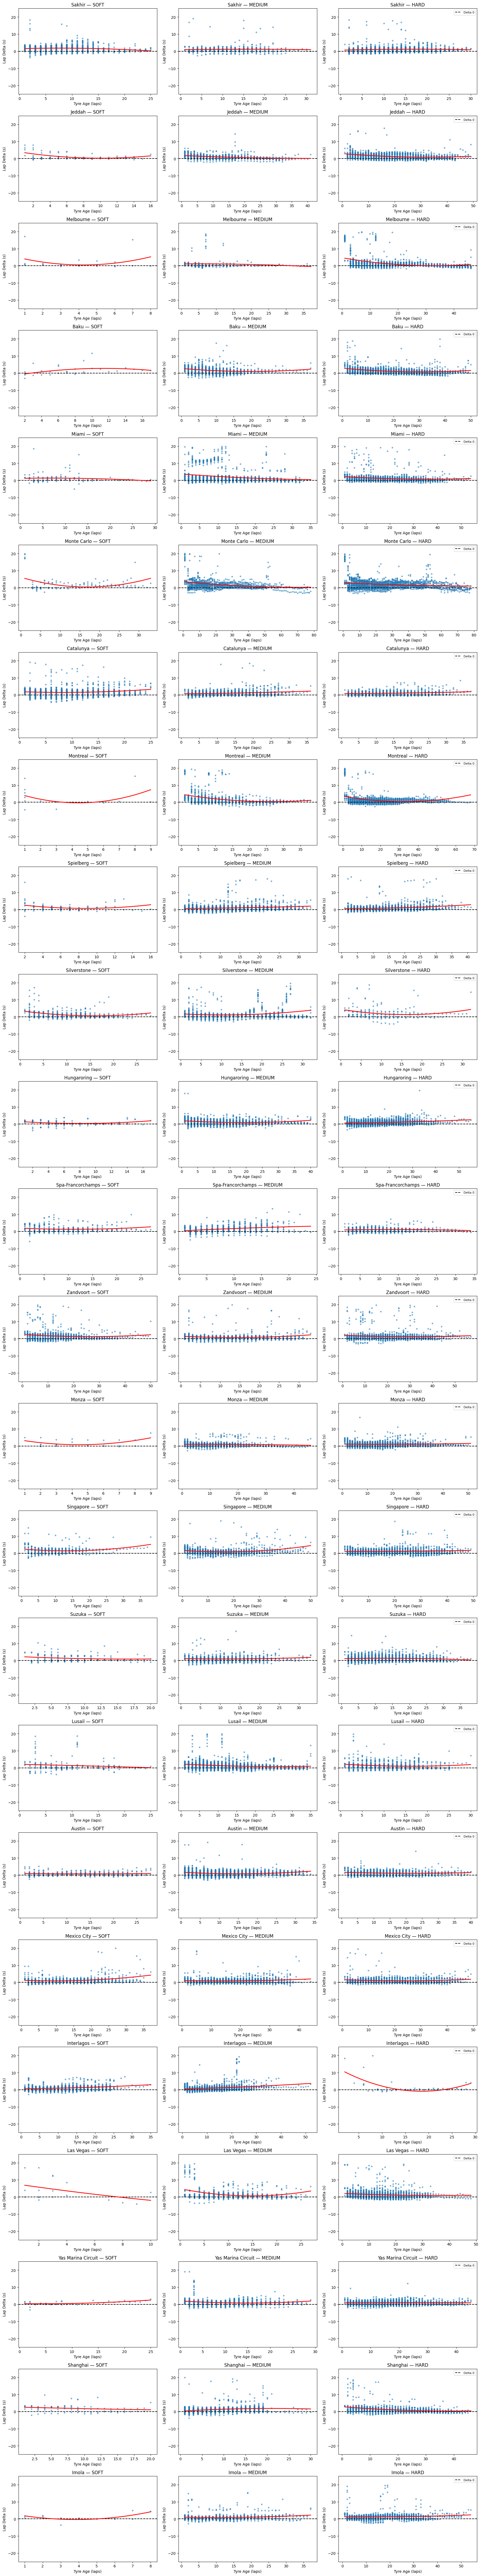

In [10]:
# Prepare the figure
fig, axes = plt.subplots(
    nrows=len(tracks),
    ncols=len(compounds),
    figsize=(18, 4 * len(tracks)),
    sharex=False, sharey=False
)

# If only 1 track or 1 compound, axes may not be 2D → fix
if len(tracks) == 1:
    axes = np.array([axes])
if len(compounds) == 1:
    axes = axes.reshape((len(tracks), 1))

for i, track in enumerate(tracks):
    for j, comp in enumerate(compounds):
        ax = axes[i, j]
        df_tc = df_delta[(df_delta["track"] == track) & (df_delta["tyre_compound"] == comp)]

        ax.set_title(f"{track} — {comp}", fontsize=12)

        if len(df_tc) == 0:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        ax.scatter(
            df_tc["tyre_age_laps"], 
            df_tc["lap_delta"], 
            s=10,
            alpha=0.5,
        )
        
        ax.axhline(y=0, color="black", linestyle="--", label="Delta 0")
        ax.set_xlabel("Tyre Age (laps)")
        ax.set_ylabel("Lap Delta (s)")

        # Fit curve only if model exists
        if (track, comp) in models:
            model = models[(track, comp)]
            X_range = np.linspace(df_tc["tyre_age_laps"].min(),
                                  df_tc["tyre_age_laps"].max(), 200).reshape(-1, 1)
            y_pred = model.predict(poly.transform(X_range))
            ax.plot(X_range, y_pred, linewidth=2, color="red")

        # Legend only on rightmost subplot per row
        if j == len(compounds) - 1:
            ax.legend(loc="upper right", fontsize=8)
        
        ax.set_ylim(-25,25)

plt.tight_layout()
plt.show()

# Creating Optimizer

In [79]:
from collections import namedtuple

# ------------------------------
# USER / RACE PARAMETERS
# ------------------------------
track = "Monza"                     # Track name
race_laps = 53                      # Total laps in race
pit_stop_overhead = 30.0            # Seconds per pitstop: 25s for Monza

tyre_tuple = namedtuple("Tyre", ["id", "compound", "init_age"])

# Example available tyres
available_tyres = [
    # Softs, used from qualifying and practice
    tyre_tuple("SOFT_0", "SOFT", 5),
    tyre_tuple("SOFT_1", "SOFT", 6),
    tyre_tuple("SOFT_2", "SOFT", 4),
    tyre_tuple("SOFT_3", "SOFT", 3),
    tyre_tuple("SOFT_4", "SOFT", 3),

    # Mediums, used from practice or new
    tyre_tuple("MED_0", "MEDIUM", 7),
    tyre_tuple("MED_1", "MEDIUM", 0),

    # Hards, used from practice
    tyre_tuple("HARD_0", "HARD", 15),
]

if len(available_tyres) not in (7, 8):
    raise ValueError("Available tyres for race day must be 7 or 8")

# Average the baseline across years for the selected track to simplify car performance
avg_baselines_dict = {}
for (trk, comp, yr), baseline in baselines_dict.items():
    if trk != track:
        continue
    key = (trk, comp)
    if key not in avg_baselines_dict:
        avg_baselines_dict[key] = []
    avg_baselines_dict[key].append(baseline)
    
for key in avg_baselines_dict:
    avg_baselines_dict[key] = sum(avg_baselines_dict[key]) / len(avg_baselines_dict[key])

In [80]:
# ------------------------------
# Helper: predict single lap time (absolute) given track, compound, tyre_age
# ------------------------------
def predict_lap_time_for_age(track_name, compound, tyre_age):
    """
    Uses models (trained on lap_delta) and baselines_dict to reconstruct absolute lap time.
    Returns lap_duration in seconds (float).
    """
    # Check if model exists for (track, compound)
    key = (track_name, compound)
    if key not in models:
        raise KeyError(f"No model for {key}. Train per-track-per-compound models first.")
    
    model = models[key]
    X_poly = poly.transform(np.array([[tyre_age]]))
    lap_delta = float(model.predict(X_poly)[0])  # predicted delta vs year baseline
    baseline = avg_baselines_dict.get((track_name, compound))

    if baseline is None:
        raise KeyError(f"No baseline for {(track_name, compound)}. Cannot predict absolute lap time.")

    return baseline + lap_delta

In [81]:
# ------------------------------
# Compute the maximum tyre_age observed for that track/compound across years.
# ------------------------------
max_age_map = {}
safety_margin = 2  # Extra laps to avoid overstepping observed data

grp = df_delta.groupby(["track", "tyre_compound"])["tyre_age_laps"].quantile(0.95).reset_index()
grp.apply(lambda row: row["tyre_age_laps"] - safety_margin, axis=1)
for _, row in grp.iterrows():
    max_age_map[(row["track"], row["tyre_compound"])] = int(row["tyre_age_laps"])

# -------------------------------------------------------------------------
# Precompute stint times for all combinations
# -------------------------------------------------------------------------
lap_time_data = {}
for tyre in available_tyres:
    tyre_id = tyre.id
    base_age = tyre.init_age
    max_age = max_age_map[(track, tyre.compound)]

    for l in range(1, min(race_laps, max_age) + 1):
        lap_time_data[(tyre_id, l)] = predict_lap_time_for_age(
            track_name=track,
            compound=tyre.compound,
            tyre_age=base_age + l - 1
        )

In [84]:
# Creating Pyomo model
import pyomo.environ as pyo
from collections import defaultdict

tyres_by_compound = defaultdict(list)

for tyre in available_tyres:
    tyres_by_compound[tyre.compound].append(tyre.id)

tyre_ids = [tyre.id for tyre in available_tyres]

model = pyo.ConcreteModel()


# -------------------------------------------------------------------------
# SETS
# -------------------------------------------------------------------------
model.tyres = pyo.Set(initialize=tyre_ids) # Tyres available
model.L = pyo.RangeSet(1, race_laps)
model.compounds = pyo.Set(initialize=list(tyres_by_compound.keys()), ordered=False)
model.tyres_by_compound = pyo.Set(
    model.compounds,
    initialize=lambda m, c: tyres_by_compound[c]
)

# -------------------------------------------------------------------------
# PARAMETERS
# -------------------------------------------------------------------------
model.tyre_age = pyo.Param(model.tyres, initialize={tyre.id: tyre.init_age for tyre in available_tyres})
model.tyre_age_max = pyo.Param(model.tyres, initialize={tyre.id: max_age_map[(track, tyre.compound)] for tyre in available_tyres})
model.lap_time = pyo.Param(
    model.tyres,
    model.L,
    initialize=lap_time_data,
    domain=pyo.NonNegativeReals,
    default=0.0
) 

# -------------------------------------------------------------------------
# VARIABLES
# -------------------------------------------------------------------------
model.laps = pyo.Var(model.tyres, domain=pyo.NonNegativeIntegers)
model.run_lap = pyo.Var(model.tyres, model.L, domain=pyo.Binary)
model.use_stint = pyo.Var(model.tyres, domain=pyo.Binary) # Stint
model.use_compound = pyo.Var(model.compounds, domain=pyo.Binary) # For mandatory min 2 types of compound used


# -------------------------------------------------------------------------
# CONSTRAINTS
# -------------------------------------------------------------------------
# Total race distance
def total_laps_rule(m):
    return sum(m.run_lap[t, l] for t in m.tyres for l in m.L) == race_laps

model.total_laps = pyo.Constraint(rule=total_laps_rule)

# Can only run laps if tyre is used
def link_stint_rule(m, t):
    return sum(m.run_lap[t, l] for l in m.L) <= race_laps * m.use_stint[t]

model.link_stint = pyo.Constraint(model.tyres, rule=link_stint_rule)

# Tyre age limit
def age_limit_rule(m, t):
    return sum(m.run_lap[t, l] for l in m.L) <= m.tyre_age_max[t] * m.use_stint[t]

model.age_limit = pyo.Constraint(model.tyres, rule=age_limit_rule)

# Contiguous laps (no skipping laps, must be sequential)
def contiguity_rule(m, t, l):
    if l == race_laps:
        return pyo.Constraint.Skip
    return m.run_lap[t, l] >= m.run_lap[t, l + 1]

model.contiguity = pyo.Constraint(model.tyres, model.L, rule=contiguity_rule)

# If any stint of that compound is used then compound is used.
def compound_usage_rule(m, c):
    return sum(
        m.laps[t] for t in m.tyres_by_compound[c]
    ) <= race_laps * m.use_compound[c]

model.compound_usage = pyo.Constraint(
    model.compounds,
    rule=compound_usage_rule
)

# Mandatory compound rule; At least 2 different compounds used
model.mandatory_compounds = pyo.Constraint(
    expr=sum(model.use_compound[c] for c in model.compounds) >= 2
)

MIN_LAPS_PER_COMPOUND = 1   # FIA minimum = 1

def compound_min_laps_rule(m, c):
    return sum(m.laps[t] for t in m.tyres_by_compound[c]) >= MIN_LAPS_PER_COMPOUND * m.use_compound[c]

model.compound_min_laps = pyo.Constraint(
    model.compounds,
    rule=compound_min_laps_rule
)

# -------------------------------------------------------------------------
# OBJECTIVE: minimize total predicted race time
# -------------------------------------------------------------------------
def total_race_time(m):
    return (
        sum(
            m.lap_time[tyre, lap] * m.run_lap[tyre, lap]
            for tyre in m.tyres
            for lap in m.L
        )
        + pit_stop_overhead * (sum(m.use_stint[tyre] for tyre in m.tyres) - 1)
    )

model.obj = pyo.Objective(rule=total_race_time, sense=pyo.minimize)

solver = pyo.SolverFactory("glpk")
results = solver.solve(model, tee=False)

In [85]:
if results.solver.termination_condition == "optimal":
    print("\n===== OPTIMIZED STRATEGY =====")

    total_time = pyo.value(model.obj)
    print(f"Total race time: {total_time:.2f} s")

    used_tyres = [t for t in model.tyres if pyo.value(model.use_stint[t]) > 0.5]
    num_stints = len(used_tyres)
    num_pitstops = max(0, num_stints - 1)

    print(f"Stints used: {num_stints}")
    print(f"Pit stops: {num_pitstops}")

    print("\n--- Stint details ---")

    for t in model.tyres:
        if pyo.value(model.use_stint[t]) > 0.5:
            stint_laps = [
                l for l in model.L
                if pyo.value(model.run_lap[t, l]) > 0.5
            ]

            stint_length = len(stint_laps)
            stint_time = sum(
                pyo.value(model.lap_time[t, l])
                for l in stint_laps
            )

            print(f"Tyre {t}:")
            print(f"  Laps run : {stint_length}")
            print(f"  Stint time: {stint_time:.2f} s")

else:
    print("Cannot find optimal strategy")


===== OPTIMIZED STRATEGY =====
Total race time: 4553.74 s
Stints used: 2
Pit stops: 1

--- Stint details ---
Tyre MED_0:
  Laps run : 25
  Stint time: 2138.67 s
Tyre HARD_0:
  Laps run : 28
  Stint time: 2385.06 s
